# Deep Q-Network implementation

This notebook shamelessly demands you to implement a DQN - an approximate q-learning algorithm with experience replay and target networks - and see if it works any better this way.

In [ ]:
#XVFB will be launched if you run on a server
import os
if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY"))==0:
    !bash ../xvfb start
    %env DISPLAY=:1

__Frameworks__ - we'll accept this homework in any deep learning framework. This particular notebook was designed for tensorflow, but you will find it easy to adapt it to almost any python-based deep learning framework.

As per DQN Atari paper:
- Epsilon-greedy: from 1.0 to 0.1 (agent.epsilon)
- learning rate: 2.5*1e-4 (tf.train.AdamOptimizer(2.5e-4)) TODO RMSprop
- load_weigths_into_target_network: every 1000 * 10 steps

BUG FIX: load_weigths_into_target_network

In [1]:
import gym
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

### Let's play some old videogames
![img](https://s17.postimg.org/y9xcab74f/nerd.png)

This time we're gonna apply approximate q-learning to an atari game called Breakout. It's not the hardest thing out there, but it's definitely way more complex than anything we tried before.


### Processing game image 

Raw atari images are large, 210x160x3 by default. However, we don't need that level of detail in order to learn them.

We can thus save a lot of time by preprocessing game image, including
* Resizing to a smaller shape, 64 x 64
* Converting to grayscale
* Cropping irrelevant image parts (top & bottom)

In [2]:
import cv2

def plotme(img):
    return
    print(img.shape)
    plt.imshow(img, interpolation='none',cmap='gray');
    plt.show()
    

In [3]:
from gym.core import ObservationWrapper
from gym.spaces import Box

from scipy.misc import imresize

class PreprocessAtari(ObservationWrapper):
    def __init__(self, env):
        """A gym wrapper that crops, scales image into the desired shapes and optionally grayscales it."""
        ObservationWrapper.__init__(self,env)
        
        #self.img_size = (64, 64)
        self.img_size = (84, 84) # Use Original DeepMind paper settings ...
        self.observation_space = Box(0.0, 1.0, (self.img_size[0], self.img_size[1], 1))

    def _observation(self, img):
        """what happens to each observation"""
        
        # Here's what you need to do:
        #  * crop image, remove irrelevant parts
        #  * resize image to self.img_size 
        #     (use imresize imported above or any library you want,
        #      e.g. opencv, skimage, PIL, keras)
        #  * cast image to grayscale
        #  * convert image pixels to (0,1) range, float32 type
        
        #<Your code here>        
        #return <...>
        
        plotme(img)
        img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        plotme(img)
        img = cv2.resize(img, (84, 110))
        plotme(img)
        img = img[17:-9, :] / 255.0
        img = np.float32(img)
        plotme(img)
        #img = cv2.resize(img, (64, 64), interpolation = cv2.INTER_NEAREST)
        #plotme(img)
        
        img = np.expand_dims(img, axis=2)
        #print(img.shape)
        
        return img


WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: <class '__main__.PreprocessAtari'> doesn't implement 'observation' method. Maybe it implements deprecated '_observation' method.
observation_shape = (84, 84, 1)
obs.ndim = 3
obs.shape = (84, 84, 1)
obs.dtype = float32
Formal tests seem fine. Here's an example of what you'll get.


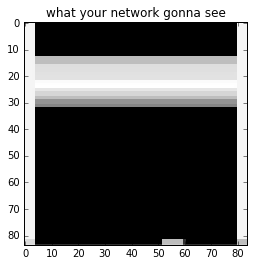

In [4]:
import gym
#spawn game instance for tests
env = gym.make("BreakoutDeterministic-v0") #create raw env
env = PreprocessAtari(env)

observation_shape = env.observation_space.shape
n_actions = env.action_space.n

obs = env.reset()

print('observation_shape = {}'.format(observation_shape))
print('obs.ndim = {}'.format(obs.ndim))
print('obs.shape = {}'.format(obs.shape))
print('obs.dtype = {}'.format(obs.dtype))


#test observation
assert obs.ndim == 3, "observation must be [batch, time, channels] even if there's just one channel"
assert obs.shape == observation_shape
assert obs.dtype == 'float32'
assert len(np.unique(obs))>2, "your image must not be binary"
assert 0 <= np.min(obs) and np.max(obs) <=1, "convert image pixels to (0,1) range"

print("Formal tests seem fine. Here's an example of what you'll get.")

plt.title("what your network gonna see")
plt.imshow(np.squeeze(obs), interpolation='none',cmap='gray');


### Frame buffer

Our agent can only process one observation at a time, so we gotta make sure it contains enough information to find optimal actions. For instance, agent has to react to moving objects so he must be able to measure object's velocity.

To do so, we introduce a buffer that stores 4 last images. This time everything is pre-implemented for you.

In [5]:
from framebuffer import FrameBuffer
def make_env():
    env = gym.make("BreakoutDeterministic-v4")
    env = PreprocessAtari(env)
    env = FrameBuffer(env, n_frames=4, dim_order='tensorflow')
    return env

env = make_env()
env.reset()
n_actions = env.action_space.n
state_dim = env.observation_space.shape

print(n_actions)
print(state_dim)

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
4
(84, 84, 4)


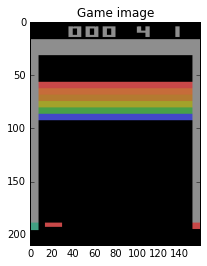

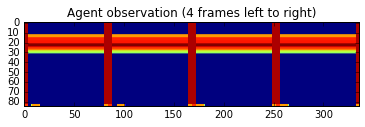

In [6]:
for _ in range(50):
    obs, _, _, _ = env.step(env.action_space.sample())


plt.title("Game image")
plt.imshow(env.render("rgb_array"))
plt.show()
plt.title("Agent observation (4 frames left to right)")
plt.imshow(obs.transpose([0,2,1]).reshape([state_dim[0],-1]));

### Building a network

We now need to build a neural network that can map images to state q-values. This network will be called on every agent's step so it better not be resnet-152 unless you have an array of GPUs. Instead, you can use strided convolutions with a small number of features to save time and memory.

You can build any architecture you want, but for reference, here's something that will more or less work:

![img](https://s17.postimg.org/ogg4xo51r/dqn_arch.png)

In [7]:
import tensorflow as tf
tf.reset_default_graph()
sess = tf.InteractiveSession()

/home/philippew/anaconda3/envs/pythonx/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [8]:
print(state_dim)
print(n_actions)
print(env.unwrapped.get_action_meanings())
print([None,])
print(list(state_dim))
print([None,] + list(state_dim))

(84, 84, 4)
4
['NOOP', 'FIRE', 'RIGHT', 'LEFT']
[None]
[84, 84, 4]
[None, 84, 84, 4]


In [9]:
print(7*7*64)

3136


In [10]:
import keras
import keras.layers as L

print(state_dim)
#input_shape = [None,] +list(state_dim)
input_shape =  list(state_dim)
print(input_shape)

# cf Original DeepMind paper
# section methods: Model Architecture
# https://github.com/PhilippeW83440/Reinforcement-Learning/blob/master/nature14236.pdf

network = keras.models.Sequential()
network.add(L.InputLayer(input_shape)) # None dim added implicitely by Keras
network.add(L.Conv2D(32, (8 , 8), strides=4, activation='relu'))
network.add(L.Conv2D(64, (4 , 4), strides=2, activation='relu'))
network.add(L.Conv2D(64, (3 , 3), strides=1, activation='relu'))
network.add(L.Flatten())
network.add(L.Dense(512, activation='relu'))
network.add(L.Dense(n_actions, activation='linear'))

print(network.summary())

state_t = tf.placeholder('float32', [None,] + list(state_dim))
print(state_t)

print("\n\n ==> qvalues: {}".format(network(state_t)))

(84, 84, 4)
[84, 84, 4]
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 84, 84, 4)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 20, 20, 32)        8224      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 9, 9, 64)          32832     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 7, 7, 64)          36928     
_________________________________________________________________
flatten_1 (Flatten)          (None, 3136)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               1606144   
_________________________________________________________________
dense_2 (Dense)              (None, 4)              

Using TensorFlow backend.


In [11]:
from keras.layers import Conv2D, Dense, Flatten
class DQNAgent:
    def __init__(self, name, state_shape, n_actions, epsilon=0, reuse=False, prev_layer=None):
        """A simple DQN agent"""
        with tf.variable_scope(name, reuse=reuse):
            
            #< Define your network body here. Please make sure you don't use any layers created elsewhere >
            self.network = keras.models.Sequential()
            self.network.add(L.InputLayer(input_shape)) # None dim added implicitely by Keras
            self.network.add(L.Conv2D(32, (8 , 8), strides=4, activation='relu'))
            self.network.add(L.Conv2D(64, (4 , 4), strides=2, activation='relu'))
            self.network.add(L.Conv2D(64, (3 , 3), strides=1, activation='relu'))
            self.network.add(L.Flatten())
            self.network.add(L.Dense(512, activation='relu'))
            self.network.add(L.Dense(n_actions, activation='linear'))
            print(self.network.summary())
            
            # prepare a graph for agent step
            self.state_t = tf.placeholder('float32', [None,] + list(state_shape))
            self.qvalues_t = self.get_symbolic_qvalues(self.state_t)
            
        self.weights = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope=name)
        self.epsilon = epsilon

    def get_symbolic_qvalues(self, state_t):
        """takes agent's observation, returns qvalues. Both are tf Tensors"""
        #< apply your network layers here >
        #qvalues = < symbolic tensor for q-values >
        qvalues = self.network(state_t)
        
        assert tf.is_numeric_tensor(qvalues) and qvalues.shape.ndims == 2, \
            "please return 2d tf tensor of qvalues [you got %s]" % repr(qvalues)
        assert int(qvalues.shape[1]) == n_actions
        
        return qvalues
    
    def get_qvalues(self, state_t):
        """Same as symbolic step except it operates on numpy arrays"""
        sess = tf.get_default_session()
        return sess.run(self.qvalues_t, {self.state_t: state_t})
    
    def sample_actions(self, qvalues):
        """pick actions given qvalues. Uses epsilon-greedy exploration strategy. """
        epsilon = self.epsilon
        batch_size, n_actions = qvalues.shape
        random_actions = np.random.choice(n_actions, size=batch_size)
        best_actions = qvalues.argmax(axis=-1)
        should_explore = np.random.choice([0, 1], batch_size, p = [1-epsilon, epsilon])
        return np.where(should_explore, random_actions, best_actions)

In [12]:
agent = DQNAgent("dqn_agent", state_dim, n_actions, epsilon=1)
sess.run(tf.global_variables_initializer())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 84, 84, 4)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 20, 20, 32)        8224      
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 9, 9, 64)          32832     
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 7, 7, 64)          36928     
_________________________________________________________________
flatten_2 (Flatten)          (None, 3136)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 512)               1606144   
_________________________________________________________________
dense_4 (Dense)              (None, 4)                 2052      
Total para

Now let's try out our agent to see if it raises any errors.

In [13]:
def evaluate(env, agent, n_games=1, greedy=False, t_max=10000):
    """ Plays n_games full games. If greedy, picks actions as argmax(qvalues). Returns mean reward. """
    rewards = []
    for _ in range(n_games):
        s = env.reset()
        reward = 0
        for _ in range(t_max):
            qvalues = agent.get_qvalues([s])
            action = qvalues.argmax(axis=-1)[0] if greedy else agent.sample_actions(qvalues)[0]
            s, r, done, _ = env.step(action)
            reward += r
            if done: break
                
        rewards.append(reward)
    return np.mean(rewards)

In [14]:
evaluate(env, agent, n_games=1)

2.0

### Experience replay
For this assignment, we provide you with experience replay buffer. If you implemented experience replay buffer in last week's assignment, you can copy-paste it here __to get 2 bonus points__.

![img](https://s17.postimg.org/ms4zvqj4v/exp_replay.png)

#### The interface is fairly simple:
* `exp_replay.add(obs, act, rw, next_obs, done)` - saves (s,a,r,s',done) tuple into the buffer
* `exp_replay.sample(batch_size)` - returns observations, actions, rewards, next_observations and is_done for `batch_size` random samples.
* `len(exp_replay)` - returns number of elements stored in replay buffer.

In [15]:
from replay_buffer import ReplayBuffer
exp_replay = ReplayBuffer(10)

for _ in range(30):
    exp_replay.add(env.reset(), env.action_space.sample(), 1.0, env.reset(), done=False)

obs_batch, act_batch, reward_batch, next_obs_batch, is_done_batch = exp_replay.sample(5)

assert len(exp_replay) == 10, "experience replay size should be 10 because that's what maximum capacity is"

In [16]:
def play_and_record(agent, env, exp_replay, n_steps=1):
    """
    Play the game for exactly n steps, record every (s,a,r,s', done) to replay buffer. 
    Whenever game ends, add record with done=True and reset the game.
    :returns: return sum of rewards over time
    
    Note: please do not env.reset() unless env is done.
    It is guaranteed that env has done=False when passed to this function.
    """
    # State at the beginning of rollout
    s = env.framebuffer
    
    # Play the game for n_steps as per instructions above
    #<YOUR CODE>
    total_reward = 0.0
    for i in range(n_steps):
        qvalues = agent.get_qvalues([s])
        action = agent.sample_actions(qvalues)[0]
        next_s, r, done, _ = env.step(action)
        
        #print(r)
        total_reward += r
        
        if exp_replay is not None:
            # store current <s,a,r,s'> transition in buffer
            exp_replay.add(s, action, r, next_s, done)
        
        if done:
            s = env.reset()
        else:
            s = next_s
        #print("total_reward={}".format(total_reward))
            
    return total_reward

In [17]:
# testing your code. This may take a minute...
exp_replay = ReplayBuffer(20000)

play_and_record(agent, env, exp_replay, n_steps=10000)
#play_and_record(agent, env, exp_replay, n_steps=1000)



# if you're using your own experience replay buffer, some of those tests may need correction. 
# just make sure you know what your code does
assert len(exp_replay) == 10000, "play_and_record should have added exactly 10000 steps, "\
                                 "but instead added %i"%len(exp_replay)
is_dones = list(zip(*exp_replay._storage))[-1]

assert 0 < np.mean(is_dones) < 0.1, "Please make sure you restart the game whenever it is 'done' and record the is_done correctly into the buffer."\
                                    "Got %f is_done rate over %i steps. [If you think it's your tough luck, just re-run the test]"%(np.mean(is_dones), len(exp_replay))
    
for _ in range(100):
    obs_batch, act_batch, reward_batch, next_obs_batch, is_done_batch = exp_replay.sample(10)
    assert obs_batch.shape == next_obs_batch.shape == (10,) + state_dim
    assert act_batch.shape == (10,), "actions batch should have shape (10,) but is instead %s"%str(act_batch.shape)
    assert reward_batch.shape == (10,), "rewards batch should have shape (10,) but is instead %s"%str(reward_batch.shape)
    assert is_done_batch.shape == (10,), "is_done batch should have shape (10,) but is instead %s"%str(is_done_batch.shape)
    assert [int(i) in (0,1) for i in is_dones], "is_done should be strictly True or False"
    assert [0 <= a <= n_actions for a in act_batch], "actions should be within [0, n_actions]"
    
print("Well done!")

Well done!


### Target networks

We also employ the so called "target network" - a copy of neural network weights to be used for reference Q-values:

The network itself is an exact copy of agent network, but it's parameters are not trained. Instead, they are moved here from agent's actual network every so often.

$$ Q_{reference}(s,a) = r + \gamma \cdot \max _{a'} Q_{target}(s',a') $$

![img](https://s17.postimg.org/x3hcoi5q7/taget_net.png)



In [18]:
target_network = DQNAgent("target_network", state_dim, n_actions)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 84, 84, 4)         0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 20, 20, 32)        8224      
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 9, 9, 64)          32832     
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 7, 7, 64)          36928     
_________________________________________________________________
flatten_3 (Flatten)          (None, 3136)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 512)               1606144   
_________________________________________________________________
dense_6 (Dense)              (None, 4)                 2052      
Total para

In [19]:
def load_weigths_into_target_network(agent, target_network):
    """ assign target_network.weights variables to their respective agent.weights values. """
    assigns = []
    for w_agent, w_target in zip(agent.weights, target_network.weights):
        assigns.append(tf.assign(w_target, w_agent, validate_shape=True))
    #tf.get_default_session().run(assigns)
    return assigns

In [20]:
# BUG FIX

#load_weigths_into_target_network(agent, target_network) 

# check that it works
#sess.run([tf.assert_equal(w, w_target) for w, w_target in zip(agent.weights, target_network.weights)]);
#print("It works!")

In [21]:


# create the tf copy graph only once.
copy_step=load_weigths_into_target_network(agent, target_network) 
sess.run(copy_step)
# check that it works
sess.run([tf.assert_equal(w, w_target) for w, w_target in zip(agent.weights, target_network.weights)]);
print("It works!")



It works!


### Learning with... Q-learning
Here we write a function similar to `agent.update` from tabular q-learning.

In [22]:
# placeholders that will be fed with exp_replay.sample(batch_size)
obs_ph = tf.placeholder(tf.float32, shape=(None,) + state_dim)
actions_ph = tf.placeholder(tf.int32, shape=[None])
rewards_ph = tf.placeholder(tf.float32, shape=[None])
next_obs_ph = tf.placeholder(tf.float32, shape=(None,) + state_dim)
is_done_ph = tf.placeholder(tf.float32, shape=[None])

is_not_done = 1 - is_done_ph
gamma = 0.99

In [23]:
print(actions_ph)
print(n_actions)

Tensor("Placeholder_2:0", shape=(?,), dtype=int32)
4


Take q-values for actions agent just took

In [24]:
current_qvalues = agent.get_symbolic_qvalues(obs_ph)
current_action_qvalues = tf.reduce_sum(tf.one_hot(actions_ph, n_actions) * current_qvalues, axis=1)

print(current_qvalues)
print(current_action_qvalues)

Tensor("sequential_2/dense_4/BiasAdd:0", shape=(?, 4), dtype=float32)
Tensor("Sum:0", shape=(?,), dtype=float32)


Compute Q-learning TD error:

$$ L = { 1 \over N} \sum_i [ Q_{\theta}(s,a) - Q_{reference}(s,a) ] ^2 $$

With Q-reference defined as

$$ Q_{reference}(s,a) = r(s,a) + \gamma \cdot max_{a'} Q_{target}(s', a') $$

Where
* $Q_{target}(s',a')$ denotes q-value of next state and next action predicted by __target_network__
* $s, a, r, s'$ are current state, action, reward and next state respectively
* $\gamma$ is a discount factor defined two cells above.

In [25]:
# compute q-values for NEXT states with target network
#next_qvalues_target = <YOUR CODE> 
next_qvalues_target = target_network.get_symbolic_qvalues(next_obs_ph)
print(next_qvalues_target)

# compute state values by taking max over next_qvalues_target for all actions
#next_state_values_target = <YOUR CODE>
next_state_values_target = tf.reduce_max(next_qvalues_target, axis=1)
print(next_state_values_target)

# compute Q_reference(s,a) as per formula above.
#reference_qvalues = <YOUR CODE>
reference_qvalues = rewards_ph + gamma * next_state_values_target * is_not_done

# Define loss function for sgd.
td_loss = (current_action_qvalues - reference_qvalues) ** 2
td_loss = tf.reduce_mean(td_loss)
print(td_loss)

train_step = tf.train.AdamOptimizer(2.5e-4).minimize(td_loss, var_list=agent.weights)
print(train_step)

Tensor("sequential_3/dense_6/BiasAdd:0", shape=(?, 4), dtype=float32)
Tensor("Max:0", shape=(?,), dtype=float32)
Tensor("Mean:0", shape=(), dtype=float32)
name: "Adam"
op: "NoOp"
input: "^Adam/update_dqn_agent/conv2d_4/kernel/ApplyAdam"
input: "^Adam/update_dqn_agent/conv2d_4/bias/ApplyAdam"
input: "^Adam/update_dqn_agent/conv2d_5/kernel/ApplyAdam"
input: "^Adam/update_dqn_agent/conv2d_5/bias/ApplyAdam"
input: "^Adam/update_dqn_agent/conv2d_6/kernel/ApplyAdam"
input: "^Adam/update_dqn_agent/conv2d_6/bias/ApplyAdam"
input: "^Adam/update_dqn_agent/dense_3/kernel/ApplyAdam"
input: "^Adam/update_dqn_agent/dense_3/bias/ApplyAdam"
input: "^Adam/update_dqn_agent/dense_4/kernel/ApplyAdam"
input: "^Adam/update_dqn_agent/dense_4/bias/ApplyAdam"
input: "^Adam/Assign"
input: "^Adam/Assign_1"



In [26]:
sess.run(tf.global_variables_initializer())

In [27]:
for chk_grad in tf.gradients(reference_qvalues, agent.weights):
    error_msg = "Reference q-values should have no gradient w.r.t. agent weights. Make sure you used target_network qvalues! "
    error_msg += "If you know what you're doing, ignore this assert."
    assert chk_grad is None or np.allclose(sess.run(chk_grad), sess.run(chk_grad * 0)), error_msg

assert tf.gradients(reference_qvalues, is_not_done)[0] is not None, "make sure you used is_not_done"
assert tf.gradients(reference_qvalues, rewards_ph)[0] is not None, "make sure you used rewards"
assert tf.gradients(reference_qvalues, next_obs_ph)[0] is not None, "make sure you used next states"
assert tf.gradients(reference_qvalues, obs_ph)[0] is None, "reference qvalues shouldn't depend on current observation!" # ignore if you're certain it's ok
print("Splendid!")

Splendid!


### Main loop

It's time to put everything together and see if it learns anything.

In [28]:
from tqdm import trange
from IPython.display import clear_output
import matplotlib.pyplot as plt
from pandas import ewma
%matplotlib inline

mean_rw_history = []
td_loss_history = []

In [31]:
print(agent.epsilon)
save_file = './model/model.ckpt'
saver = tf.train.Saver()

1


In [32]:
saver.restore(sess, save_file)

INFO:tensorflow:Restoring parameters from ./model/model.ckpt


In [34]:
agent.epsilon = 0.01
print(agent.epsilon)

0.01


In [35]:
exp_replay = ReplayBuffer(10**5)
play_and_record(agent, env, exp_replay, n_steps=10000)

def sample_batch(exp_replay, batch_size):
    obs_batch, act_batch, reward_batch, next_obs_batch, is_done_batch = exp_replay.sample(batch_size)
    return {
        obs_ph:obs_batch, actions_ph:act_batch, rewards_ph:reward_batch, 
        next_obs_ph:next_obs_batch, is_done_ph:is_done_batch
    }

buffer size = 100000, epsilon = 0.01000, mean reward = 412.00


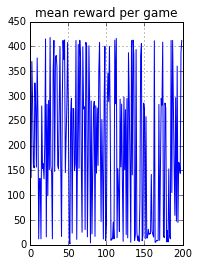

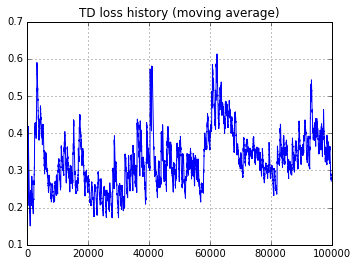

100%|██████████| 100000/100000 [1:10:28<00:00, 23.65it/s]


In [36]:
for i in trange(10**5):
    
    # play
    play_and_record(agent, env, exp_replay, 10)
    
    # train
    _, loss_t = sess.run([train_step, td_loss], sample_batch(exp_replay, batch_size=64))
    td_loss_history.append(loss_t)
    
    # adjust agent parameters
    if i % 1000 == 0:
        #load_weigths_into_target_network(agent, target_network)
        #calling 'load_weights_into_target_network' repeatedly cause creating tf copy operator
        #again and again, which bloat memory consumption along training step
        #create'copy_step' once
        sess.run(copy_step)
        agent.epsilon = max(agent.epsilon * 0.99, 0.01)     
        
    if i % 500 == 0:
        mean_rw_history.append(evaluate(make_env(), agent, n_games=3))
    
    if i % 100 == 0:
        clear_output(True)
        print("buffer size = %i, epsilon = %.5f, mean reward = %.2f"  % (len(exp_replay), agent.epsilon, mean_rw_history[-1]))
        
        plt.subplot(1,2,1)
        plt.title("mean reward per game")
        plt.plot(mean_rw_history)
        plt.grid()

        assert not np.isnan(loss_t)
        plt.figure(figsize=[12, 4])
        plt.subplot(1,2,2)
        plt.title("TD loss history (moving average)")
        plt.plot(pd.ewma(np.array(td_loss_history), span=1000, min_periods=100))
        plt.grid()
        plt.show()
        
    if i > 1 and i % 10**4 == 0:
        saver = tf.train.Saver()
        save_path = saver.save(sess, "./model/model.ckpt")
          

In [38]:
print(np.mean(mean_rw_history[-100:]))
print(agent.epsilon)

159.10333333333335
0.01


In [ ]:
assert np.mean(mean_rw_history[-10:]) > 10.
print("That's good enough for tutorial.")

In [ ]:
# CONTINUE

for i in trange(3*10**5):
    
    # play
    play_and_record(agent, env, exp_replay, 10)
    
    # train
    _, loss_t = sess.run([train_step, td_loss], sample_batch(exp_replay, batch_size=64))
    td_loss_history.append(loss_t)
    
    # adjust agent parameters
    if i % 1000 == 0:
        #load_weigths_into_target_network(agent, target_network)
        #calling 'load_weights_into_target_network' repeatedly cause creating tf copy operator
        #again and again, which bloat memory consumption along training step
        #create'copy_step' once
        sess.run(copy_step)
        agent.epsilon = max(agent.epsilon * 0.99, 0.01)     
        
    if i % 500 == 0:
        mean_rw_history.append(evaluate(make_env(), agent, n_games=3))
    
    if i % 100 == 0:
        clear_output(True)
        print("buffer size = %i, epsilon = %.5f, mean reward = %.2f"  % (len(exp_replay), agent.epsilon, mean_rw_history[-1]))
        
        plt.subplot(1,2,1)
        plt.title("mean reward per game")
        plt.plot(mean_rw_history)
        plt.grid()

        assert not np.isnan(loss_t)
        plt.figure(figsize=[12, 4])
        plt.subplot(1,2,2)
        plt.title("TD loss history (moving average)")
        plt.plot(pd.ewma(np.array(td_loss_history), span=1000, min_periods=100))
        plt.grid()
        plt.show()
        
    if i % 10**4 == 0:
        saver = tf.train.Saver()
        save_path = saver.save(sess, "./model/model.ckpt")
          

In [ ]:
print(np.mean(mean_rw_history[-100:]))
print(agent.epsilon)

In [ ]:
# CONTINUE

for i in trange(2*10**5):
    
    # play
    play_and_record(agent, env, exp_replay, 10)
    
    # train
    _, loss_t = sess.run([train_step, td_loss], sample_batch(exp_replay, batch_size=64))
    td_loss_history.append(loss_t)
    
    # adjust agent parameters
    if i % 1000 == 0:
        #load_weigths_into_target_network(agent, target_network)
        #calling 'load_weights_into_target_network' repeatedly cause creating tf copy operator
        #again and again, which bloat memory consumption along training step
        #create'copy_step' once
        sess.run(copy_step)
        agent.epsilon = max(agent.epsilon * 0.99, 0.01)     
        
    if i % 500 == 0:
        mean_rw_history.append(evaluate(make_env(), agent, n_games=3))
    
    if i % 100 == 0:
        clear_output(True)
        print("buffer size = %i, epsilon = %.5f, mean reward = %.2f"  % (len(exp_replay), agent.epsilon, mean_rw_history[-1]))
        
        plt.subplot(1,2,1)
        plt.title("mean reward per game")
        plt.plot(mean_rw_history)
        plt.grid()

        assert not np.isnan(loss_t)
        plt.figure(figsize=[12, 4])
        plt.subplot(1,2,2)
        plt.title("TD loss history (moving average)")
        plt.plot(pd.ewma(np.array(td_loss_history), span=1000, min_periods=100))
        plt.grid()
        plt.show()
        
    if i % 10**4 == 0:
        saver = tf.train.Saver()
        save_path = saver.save(sess, "./model/model.ckpt")

In [ ]:
print(np.mean(mean_rw_history[-100:]))
print(agent.epsilon)

In [ ]:
# CONTINUE
for i in trange(2*10**5):
    
    # play
    play_and_record(agent, env, exp_replay, 10)
    
    # train
    _, loss_t = sess.run([train_step, td_loss], sample_batch(exp_replay, batch_size=64))
    td_loss_history.append(loss_t)
    
    # adjust agent parameters
    if i % 1000 == 0:
        #load_weigths_into_target_network(agent, target_network)
        #calling 'load_weights_into_target_network' repeatedly cause creating tf copy operator
        #again and again, which bloat memory consumption along training step
        #create'copy_step' once
        sess.run(copy_step)
        agent.epsilon = max(agent.epsilon * 0.99, 0.01)     
        
    if i % 500 == 0:
        mean_rw_history.append(evaluate(make_env(), agent, n_games=3))
    
    if i % 100 == 0:
        clear_output(True)
        print("buffer size = %i, epsilon = %.5f, mean reward = %.2f"  % (len(exp_replay), agent.epsilon, mean_rw_history[-1]))
        
        plt.subplot(1,2,1)
        plt.title("mean reward per game")
        plt.plot(mean_rw_history)
        plt.grid()

        assert not np.isnan(loss_t)
        plt.figure(figsize=[12, 4])
        plt.subplot(1,2,2)
        plt.title("TD loss history (moving average)")
        plt.plot(pd.ewma(np.array(td_loss_history), span=1000, min_periods=100))
        plt.grid()
        plt.show()
        
    if i % 10**4 == 0:
        saver = tf.train.Saver()
        save_path = saver.save(sess, "./model/model.ckpt")

In [ ]:
print(agent.epsilon)

__ How to interpret plots: __


This aint no supervised learning so don't expect anything to improve monotonously. 
* __ TD loss __ is the MSE between agent's current Q-values and target Q-values. It may slowly increase or decrease, it's ok. The "not ok" behavior includes going NaN or stayng at exactly zero before agent has perfect performance.
* __ mean reward__ is the expected sum of r(s,a) agent gets over the full game session. It will oscillate, but on average it should get higher over time (after a few thousand iterations...). 
 * In basic q-learning implementation it takes 5-10k steps to "warm up" agent before it starts to get better.
* __ buffer size__ - this one is simple. It should go up and cap at max size.
* __ epsilon__ - agent's willingness to explore. If you see that agent's already at 0.01 epsilon before it's average reward is above 0 - __ it means you need to increase epsilon__. Set it back to some 0.2 - 0.5 and decrease the pace at which it goes down.
* Also please ignore first 100-200 steps of each plot - they're just oscillations because of the way moving average works.

At first your agent will lose quickly. Then it will learn to suck less and at least hit the ball a few times before it loses. Finally it will learn to actually score points.

__Training will take time.__ A lot of it actually. An optimistic estimate is to say it's gonna start winning (average reward > 10) after 10k steps. 

But hey, look on the bright side of things:

![img](https://s17.postimg.org/hy2v7r8hr/my_bot_is_training.png)

### Video

In [ ]:
agent.epsilon=0 # Don't forget to reset epsilon back to previous value if you want to go on training

In [ ]:
#record sessions
import gym.wrappers
env_monitor = gym.wrappers.Monitor(make_env(),directory="videos",force=True)
sessions = [evaluate(env_monitor, agent, n_games=1) for _ in range(100)]
env_monitor.close()

In [ ]:
#show video
from IPython.display import HTML
import os

video_names = list(filter(lambda s:s.endswith(".mp4"),os.listdir("./videos/")))

HTML("""
<video width="640" height="480" controls>
  <source src="{}" type="video/mp4">
</video>
""".format("./videos/"+video_names[-1])) #this may or may not be _last_ video. Try other indices

## More

If you want to play with DQN a bit more, here's a list of things you can try with it:

### Easy:
* Implementing __double q-learning__ shouldn't be a problem if you've already have target networks in place.
  * You will probably need `tf.argmax` to select best actions
  * Here's an original [article](https://arxiv.org/abs/1509.06461)

* __Dueling__ architecture is also quite straightforward if you have standard DQN.
  * You will need to change network architecture, namely the q-values layer
  * It must now contain two heads: V(s) and A(s,a), both dense layers
  * You should then add them up via elemwise sum layer.
  * Here's an [article](https://arxiv.org/pdf/1511.06581.pdf)

### Hard: Prioritized experience replay

In this section, you're invited to implement prioritized experience replay

* You will probably need to provide a custom data structure
* Once pool.update is called, collect the pool.experience_replay.observations, actions, rewards and is_alive and store them in your data structure
* You can now sample such transitions in proportion to the error (see [article](https://arxiv.org/abs/1511.05952)) for training.

It's probably more convenient to explicitly declare inputs for "sample observations", "sample actions" and so on to plug them into q-learning.

Prioritized (and even normal) experience replay should greatly reduce amount of game sessions you need to play in order to achieve good performance. 

While it's effect on runtime is limited for atari, more complicated envs (further in the course) will certainly benefit for it.

There is even more out there - see this [overview article](https://arxiv.org/abs/1710.02298).

In [ ]:
print(agent)

In [ ]:
def evaluate(env, agent, n_games=1, greedy=False, t_max=10000):
    """ Plays n_games full games. If greedy, picks actions as argmax(qvalues). Returns mean reward. """
    rewards = []
    for _ in range(n_games):
        s = env.reset()
        reward = 0
        for _ in range(t_max):
            qvalues = agent.get_qvalues([s])
            action = qvalues.argmax(axis=-1)[0] if greedy else agent.sample_actions(qvalues)[0]
            s, r, done, _ = env.step(action)
            reward += r
            if done: break
                
        rewards.append(reward)
    return np.mean(rewards)

In [ ]:
def submit_breakout(agent, env, evaluate, email, token):
    sessions = [evaluate(env, agent, n_games=1) for _ in range(100)]
    print(sessions)
    session_rewards = np.array(sessions)
    grader = grading.Grader("WTOZHCn1EeiNwAoZNi-Hrg")
    grader.set_answer("VFM7Z", int(np.mean(session_rewards)))
    grader.submit(email, token)

In [ ]:
from submit import submit_breakout
env = make_env()
submit_breakout(agent, env, evaluate, 'philippe.weingertner@laposte.net', 'lbQyFB9ebBLJPhql')